In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Install dependencies

In [2]:
!pip install -U -q segmentation-models
#!pip uninstall tensorflow
!pip install tensorflow==2.7

     |████████████████████████████████| 50 kB 7.2 MB/s 
     |████████████████████████████████| 489.6 MB 22 kB/s 
     |████████████████████████████████| 463 kB 62.0 MB/s 
     |████████████████████████████████| 1.3 MB 52.0 MB/s 
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.8.0
    Uninstalling tensorflow-estimator-2.8.0:
      Successfully uninstalled tensorflow-estimator-2.8.0
  Attempting uninstall: keras
    Found existing installation: keras 2.8.0
    Uninstalling keras-2.8.0:
      Successfully uninstalled keras-2.8.0
  Attempting uninstall: gast
    Found existing installation: gast 0.5.3
    Uninstalling gast-0.5.3:
      Successfully uninstalled gast-0.5.3
  Attempting uninstall: tensorflow
    Found existing installation: tensorflow 2.8.0+zzzcolab20220506162203
    Uninstalling tensorflow-2.8.0+zzzcolab20220506162203:
      Successfully uninstalled tensorflow-2.8.0+zzzcolab20220506162203


**Import libraries**

In [25]:
import tensorflow as tf
import segmentation_models as sm
import glob
from tensorflow.keras.layers import *
from keras import backend as K
from keras.applications.vgg16 import VGG16
from keras.utils.vis_utils import plot_model
import cv2
import os
from matplotlib import pyplot as plt
import keras 
from tensorflow.keras.utils import normalize
from keras.metrics import MeanIoU
import numpy as np
from skimage.transform import AffineTransform, warp
import torchvision.models as models
from skimage import io, img_as_ubyte
from tensorflow.keras.models import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.layers import *
import random
from random import randint,choice
from scipy.ndimage import rotate
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from natsort import natsorted
from tensorflow.keras.models import Sequential,  Model
from keras import Sequential, layers
from keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D,BatchNormalization,Add,GlobalAveragePooling2D,UpSampling2D


In [ ]:
from enum import Enum
import numpy as np
from scipy.ndimage import distance_transform_edt as distance
import tensorflow as tf
import tensorflow.keras as K


# Define all possible losses
class Loss(Enum):
    CROSSENTROPY = 0,
    DICE = 1,
    ACTIVECONTOURS = 2,
    SURFACEnDice = 3,
    FOCALLOSS = 4,
    WEIGHTEDCROSSENTROPY = 5,
    WEIGHTED60CROSSENTROPY = 6,
    WEIGHTED70CROSSENTROPY = 7,
    CROSSENTROPY50DICE50 = 8,
    CROSSENTROPY25DICE75 = 9,
    CROSSENTROPY75DICE25 = 10,
    WEIGHTEDCROSSENTROPY50DICE50 = 11,
    WEIGHTEDCROSSENTROPY25DICE75 = 12,
    WEIGHTEDCROSSENTROPY75DICE25 = 13


alpha = K.backend.variable(1.0, dtype='float32')

"""
Scheduling example
alpha = K.variable(1.0, dtype='float32')
class AlphaScheduler(Callback):
 def on_epoch_end(self, epoch, logs=None):
  alpha_ = K.get_value(alpha)
  alpha_ -= 0.01
  if alpha_ < 0.1:
   alpha_ = 0.1
  K.set_value(alpha, alpha_)
  print(alpha_)
"""


def calc_dist_map(seg):
    res = np.zeros_like(seg)
    posmask = seg.astype(np.bool)
    if posmask.any():
        negmask = ~posmask
        res = distance(negmask) * negmask - (distance(posmask) - 1) * posmask
    return res

#get weight matrix for tensor (image or images stack)
def get_weight_matrix(y_true):
    y_true = K.backend.cast(y_true, 'float32')
    # if we want to get same size of output, kernel size must be odd number
    #averaged_mask = K.pool2d(
    #    y_true, pool_size=(11, 11), strides=(1, 1), padding='same', pool_mode='avg')
    #border = K.cast(K.greater(averaged_mask, 0.005), 'float32') * K.cast(K.less(averaged_mask, 0.995), 'float32')
    # basically finds label, (non-black) points in tensor
    labelmatrix = K.backend.cast(K.backend.greater(y_true, 0.5), 'float32')
    weight = K.backend.ones_like(y_true)
    w0 = K.backend.sum(weight)
    weight += labelmatrix
    w1 = K.backend.sum(weight)
    weight *= (w0 / w1)
    return weight

def binary_crossentropy(y_true, y_pred):
    loss = tf.reduce_mean(tf.keras.losses.binary_crossentropy(y_true = y_true, y_pred = y_pred, from_logits = False))
    return loss

def dice_score(y_true, y_pred):
    smooth = K.backend.epsilon()
    y_true_f = K.backend.flatten(y_true)
    y_pred_f = K.backend.flatten(y_pred)
    intersection = K.backend.sum(y_true_f * y_pred_f)
    answer = (2. * intersection + smooth) / (K.backend.sum(y_true_f) + K.backend.sum(y_pred_f) + smooth)
    return answer

**Data Pre-processing using custom data generators**

In [4]:
def rotation(image, seed):
    random.seed(seed)
    angle= random.randint(-180,180)
    r_img = rotate(image, angle, mode='reflect', reshape=False, order=0)
    return r_img

def h_flip(image, seed):
    hflipped_img= np.fliplr(image)
    return  hflipped_img

def v_flip(image, seed):
    vflipped_img= np.flipud(image)
    return vflipped_img

def v_transl(image, seed):
    random.seed(seed)
    n_pixels = random.randint(-64,64)
    vtranslated_img = np.roll(image, n_pixels, axis=0)
    return vtranslated_img

def h_transl(image, seed):
    random.seed(seed)
    n_pixels = random.randint(-64,64)
    htranslated_img = np.roll(image, n_pixels, axis=1)
    return htranslated_img
seed_for_random = 42
transformations = {'rotate': rotation,
                      'horizontal flip': h_flip, 
                      'vertical flip': v_flip,
                   'vertical shift': v_transl,
                   'horizontal shift': h_transl
                 }                #use dictionary to store names of functions 

images_path="/content/drive/MyDrive/dataset1 - Copy/images_prepped_train" #path to original images
masks_path = "/content/drive/MyDrive/dataset1 - Copy/annotations_prepped_train"
img_augmented_path="/content/drive/MyDrive/dataset1 - Copy/images_prepped_train" # path to store aumented images
msk_augmented_path="/content/drive/MyDrive/dataset1 - Copy/annotations_prepped_train" # path to store aumented images
images=[] # to store paths of images from folder
masks=[]

for im in os.listdir(images_path):  # read image name from folder and append its path into "images" array     
    images.append(os.path.join(images_path,im))

for msk in os.listdir(masks_path):  # read image name from folder and append its path into "images" array     
    masks.append(os.path.join(masks_path,msk))

i=0   # variable to iterate till images_to_generate

while i<367: 
    image = images[i]
    mask = masks[i]
    original_image = io.imread(image)
    original_mask = io.imread(mask)
    transformed_image = None
    transformed_mask = None
    key = np.random.choice(list(transformations)) #randomly choosing method to call
    print(key)
    seed = random.randint(1,100)  #Generate seed to supply transformation functions. 
    transformed_image = transformations[key](original_image, seed)
    transformed_mask = transformations[key](original_mask, seed)
    new_image_path= "%s/augmented_image_%s.png" %(img_augmented_path, i)
    new_mask_path = "%s/augmented_mask_%s.png" %(msk_augmented_path, i)   #Do not save as JPG
    io.imsave(new_image_path, transformed_image)
    io.imsave(new_mask_path, transformed_mask)
    i =i+1


rotate


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:64: UserWarning: /content/drive/MyDrive/dataset1 - Copy/annotations_prepped_train/augmented_mask_0.png is a low contrast image


horizontal shift


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:64: UserWarning: /content/drive/MyDrive/dataset1 - Copy/annotations_prepped_train/augmented_mask_1.png is a low contrast image


horizontal flip


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:64: UserWarning: /content/drive/MyDrive/dataset1 - Copy/annotations_prepped_train/augmented_mask_2.png is a low contrast image


vertical shift


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:64: UserWarning: /content/drive/MyDrive/dataset1 - Copy/annotations_prepped_train/augmented_mask_3.png is a low contrast image


horizontal shift


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:64: UserWarning: /content/drive/MyDrive/dataset1 - Copy/annotations_prepped_train/augmented_mask_4.png is a low contrast image


rotate


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:64: UserWarning: /content/drive/MyDrive/dataset1 - Copy/annotations_prepped_train/augmented_mask_5.png is a low contrast image


horizontal flip


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:64: UserWarning: /content/drive/MyDrive/dataset1 - Copy/annotations_prepped_train/augmented_mask_6.png is a low contrast image


vertical shift


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:64: UserWarning: /content/drive/MyDrive/dataset1 - Copy/annotations_prepped_train/augmented_mask_7.png is a low contrast image


vertical flip


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:64: UserWarning: /content/drive/MyDrive/dataset1 - Copy/annotations_prepped_train/augmented_mask_8.png is a low contrast image


rotate


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:64: UserWarning: /content/drive/MyDrive/dataset1 - Copy/annotations_prepped_train/augmented_mask_9.png is a low contrast image


horizontal shift


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:64: UserWarning: /content/drive/MyDrive/dataset1 - Copy/annotations_prepped_train/augmented_mask_10.png is a low contrast image


vertical shift


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:64: UserWarning: /content/drive/MyDrive/dataset1 - Copy/annotations_prepped_train/augmented_mask_11.png is a low contrast image


horizontal shift


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:64: UserWarning: /content/drive/MyDrive/dataset1 - Copy/annotations_prepped_train/augmented_mask_12.png is a low contrast image


horizontal flip


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:64: UserWarning: /content/drive/MyDrive/dataset1 - Copy/annotations_prepped_train/augmented_mask_13.png is a low contrast image


rotate


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:64: UserWarning: /content/drive/MyDrive/dataset1 - Copy/annotations_prepped_train/augmented_mask_14.png is a low contrast image


vertical shift


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:64: UserWarning: /content/drive/MyDrive/dataset1 - Copy/annotations_prepped_train/augmented_mask_15.png is a low contrast image


horizontal shift


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:64: UserWarning: /content/drive/MyDrive/dataset1 - Copy/annotations_prepped_train/augmented_mask_16.png is a low contrast image


horizontal shift


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:64: UserWarning: /content/drive/MyDrive/dataset1 - Copy/annotations_prepped_train/augmented_mask_17.png is a low contrast image


horizontal shift


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:64: UserWarning: /content/drive/MyDrive/dataset1 - Copy/annotations_prepped_train/augmented_mask_18.png is a low contrast image


vertical flip


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:64: UserWarning: /content/drive/MyDrive/dataset1 - Copy/annotations_prepped_train/augmented_mask_19.png is a low contrast image


rotate


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:64: UserWarning: /content/drive/MyDrive/dataset1 - Copy/annotations_prepped_train/augmented_mask_20.png is a low contrast image


vertical shift


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:64: UserWarning: /content/drive/MyDrive/dataset1 - Copy/annotations_prepped_train/augmented_mask_21.png is a low contrast image


rotate


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:64: UserWarning: /content/drive/MyDrive/dataset1 - Copy/annotations_prepped_train/augmented_mask_22.png is a low contrast image


rotate


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:64: UserWarning: /content/drive/MyDrive/dataset1 - Copy/annotations_prepped_train/augmented_mask_23.png is a low contrast image


vertical shift


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:64: UserWarning: /content/drive/MyDrive/dataset1 - Copy/annotations_prepped_train/augmented_mask_24.png is a low contrast image


horizontal shift


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:64: UserWarning: /content/drive/MyDrive/dataset1 - Copy/annotations_prepped_train/augmented_mask_25.png is a low contrast image


vertical shift


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:64: UserWarning: /content/drive/MyDrive/dataset1 - Copy/annotations_prepped_train/augmented_mask_26.png is a low contrast image


vertical flip


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:64: UserWarning: /content/drive/MyDrive/dataset1 - Copy/annotations_prepped_train/augmented_mask_27.png is a low contrast image


rotate


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:64: UserWarning: /content/drive/MyDrive/dataset1 - Copy/annotations_prepped_train/augmented_mask_28.png is a low contrast image


rotate


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:64: UserWarning: /content/drive/MyDrive/dataset1 - Copy/annotations_prepped_train/augmented_mask_29.png is a low contrast image


horizontal shift


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:64: UserWarning: /content/drive/MyDrive/dataset1 - Copy/annotations_prepped_train/augmented_mask_30.png is a low contrast image


vertical flip


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:64: UserWarning: /content/drive/MyDrive/dataset1 - Copy/annotations_prepped_train/augmented_mask_31.png is a low contrast image


vertical flip


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:64: UserWarning: /content/drive/MyDrive/dataset1 - Copy/annotations_prepped_train/augmented_mask_32.png is a low contrast image


rotate


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:64: UserWarning: /content/drive/MyDrive/dataset1 - Copy/annotations_prepped_train/augmented_mask_33.png is a low contrast image


vertical shift


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:64: UserWarning: /content/drive/MyDrive/dataset1 - Copy/annotations_prepped_train/augmented_mask_34.png is a low contrast image


horizontal flip


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:64: UserWarning: /content/drive/MyDrive/dataset1 - Copy/annotations_prepped_train/augmented_mask_35.png is a low contrast image


vertical flip


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:64: UserWarning: /content/drive/MyDrive/dataset1 - Copy/annotations_prepped_train/augmented_mask_36.png is a low contrast image


rotate


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:64: UserWarning: /content/drive/MyDrive/dataset1 - Copy/annotations_prepped_train/augmented_mask_37.png is a low contrast image


rotate


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:64: UserWarning: /content/drive/MyDrive/dataset1 - Copy/annotations_prepped_train/augmented_mask_38.png is a low contrast image


vertical shift


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:64: UserWarning: /content/drive/MyDrive/dataset1 - Copy/annotations_prepped_train/augmented_mask_39.png is a low contrast image


horizontal shift


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:64: UserWarning: /content/drive/MyDrive/dataset1 - Copy/annotations_prepped_train/augmented_mask_40.png is a low contrast image


horizontal shift


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:64: UserWarning: /content/drive/MyDrive/dataset1 - Copy/annotations_prepped_train/augmented_mask_41.png is a low contrast image


rotate


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:64: UserWarning: /content/drive/MyDrive/dataset1 - Copy/annotations_prepped_train/augmented_mask_42.png is a low contrast image


rotate


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:64: UserWarning: /content/drive/MyDrive/dataset1 - Copy/annotations_prepped_train/augmented_mask_43.png is a low contrast image


vertical shift


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:64: UserWarning: /content/drive/MyDrive/dataset1 - Copy/annotations_prepped_train/augmented_mask_44.png is a low contrast image


horizontal flip


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:64: UserWarning: /content/drive/MyDrive/dataset1 - Copy/annotations_prepped_train/augmented_mask_45.png is a low contrast image


horizontal shift


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:64: UserWarning: /content/drive/MyDrive/dataset1 - Copy/annotations_prepped_train/augmented_mask_46.png is a low contrast image


rotate


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:64: UserWarning: /content/drive/MyDrive/dataset1 - Copy/annotations_prepped_train/augmented_mask_47.png is a low contrast image


vertical flip


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:64: UserWarning: /content/drive/MyDrive/dataset1 - Copy/annotations_prepped_train/augmented_mask_48.png is a low contrast image


rotate


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:64: UserWarning: /content/drive/MyDrive/dataset1 - Copy/annotations_prepped_train/augmented_mask_49.png is a low contrast image


vertical shift


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:64: UserWarning: /content/drive/MyDrive/dataset1 - Copy/annotations_prepped_train/augmented_mask_50.png is a low contrast image


vertical flip


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:64: UserWarning: /content/drive/MyDrive/dataset1 - Copy/annotations_prepped_train/augmented_mask_51.png is a low contrast image


horizontal flip


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:64: UserWarning: /content/drive/MyDrive/dataset1 - Copy/annotations_prepped_train/augmented_mask_52.png is a low contrast image


horizontal shift


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:64: UserWarning: /content/drive/MyDrive/dataset1 - Copy/annotations_prepped_train/augmented_mask_53.png is a low contrast image


vertical shift


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:64: UserWarning: /content/drive/MyDrive/dataset1 - Copy/annotations_prepped_train/augmented_mask_54.png is a low contrast image


vertical shift


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:64: UserWarning: /content/drive/MyDrive/dataset1 - Copy/annotations_prepped_train/augmented_mask_55.png is a low contrast image


horizontal flip


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:64: UserWarning: /content/drive/MyDrive/dataset1 - Copy/annotations_prepped_train/augmented_mask_56.png is a low contrast image


vertical shift


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:64: UserWarning: /content/drive/MyDrive/dataset1 - Copy/annotations_prepped_train/augmented_mask_57.png is a low contrast image


rotate


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:64: UserWarning: /content/drive/MyDrive/dataset1 - Copy/annotations_prepped_train/augmented_mask_58.png is a low contrast image


vertical shift


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:64: UserWarning: /content/drive/MyDrive/dataset1 - Copy/annotations_prepped_train/augmented_mask_59.png is a low contrast image


horizontal flip


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:64: UserWarning: /content/drive/MyDrive/dataset1 - Copy/annotations_prepped_train/augmented_mask_60.png is a low contrast image


horizontal shift


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:64: UserWarning: /content/drive/MyDrive/dataset1 - Copy/annotations_prepped_train/augmented_mask_61.png is a low contrast image


rotate


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:64: UserWarning: /content/drive/MyDrive/dataset1 - Copy/annotations_prepped_train/augmented_mask_62.png is a low contrast image


horizontal flip


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:64: UserWarning: /content/drive/MyDrive/dataset1 - Copy/annotations_prepped_train/augmented_mask_63.png is a low contrast image


rotate


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:64: UserWarning: /content/drive/MyDrive/dataset1 - Copy/annotations_prepped_train/augmented_mask_64.png is a low contrast image


horizontal shift


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:64: UserWarning: /content/drive/MyDrive/dataset1 - Copy/annotations_prepped_train/augmented_mask_65.png is a low contrast image


vertical flip


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:64: UserWarning: /content/drive/MyDrive/dataset1 - Copy/annotations_prepped_train/augmented_mask_66.png is a low contrast image


vertical shift


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:64: UserWarning: /content/drive/MyDrive/dataset1 - Copy/annotations_prepped_train/augmented_mask_67.png is a low contrast image


horizontal shift


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:64: UserWarning: /content/drive/MyDrive/dataset1 - Copy/annotations_prepped_train/augmented_mask_68.png is a low contrast image


vertical flip


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:64: UserWarning: /content/drive/MyDrive/dataset1 - Copy/annotations_prepped_train/augmented_mask_69.png is a low contrast image


horizontal shift


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:64: UserWarning: /content/drive/MyDrive/dataset1 - Copy/annotations_prepped_train/augmented_mask_70.png is a low contrast image


horizontal flip


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:64: UserWarning: /content/drive/MyDrive/dataset1 - Copy/annotations_prepped_train/augmented_mask_71.png is a low contrast image


horizontal flip


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:64: UserWarning: /content/drive/MyDrive/dataset1 - Copy/annotations_prepped_train/augmented_mask_72.png is a low contrast image


rotate


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:64: UserWarning: /content/drive/MyDrive/dataset1 - Copy/annotations_prepped_train/augmented_mask_73.png is a low contrast image


vertical flip


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:64: UserWarning: /content/drive/MyDrive/dataset1 - Copy/annotations_prepped_train/augmented_mask_74.png is a low contrast image


rotate


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:64: UserWarning: /content/drive/MyDrive/dataset1 - Copy/annotations_prepped_train/augmented_mask_75.png is a low contrast image


vertical shift


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:64: UserWarning: /content/drive/MyDrive/dataset1 - Copy/annotations_prepped_train/augmented_mask_76.png is a low contrast image


vertical flip


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:64: UserWarning: /content/drive/MyDrive/dataset1 - Copy/annotations_prepped_train/augmented_mask_77.png is a low contrast image


rotate


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:64: UserWarning: /content/drive/MyDrive/dataset1 - Copy/annotations_prepped_train/augmented_mask_78.png is a low contrast image


rotate


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:64: UserWarning: /content/drive/MyDrive/dataset1 - Copy/annotations_prepped_train/augmented_mask_79.png is a low contrast image


rotate


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:64: UserWarning: /content/drive/MyDrive/dataset1 - Copy/annotations_prepped_train/augmented_mask_80.png is a low contrast image


vertical flip


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:64: UserWarning: /content/drive/MyDrive/dataset1 - Copy/annotations_prepped_train/augmented_mask_81.png is a low contrast image


horizontal shift


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:64: UserWarning: /content/drive/MyDrive/dataset1 - Copy/annotations_prepped_train/augmented_mask_82.png is a low contrast image


horizontal flip


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:64: UserWarning: /content/drive/MyDrive/dataset1 - Copy/annotations_prepped_train/augmented_mask_83.png is a low contrast image


horizontal flip


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:64: UserWarning: /content/drive/MyDrive/dataset1 - Copy/annotations_prepped_train/augmented_mask_84.png is a low contrast image


horizontal shift


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:64: UserWarning: /content/drive/MyDrive/dataset1 - Copy/annotations_prepped_train/augmented_mask_85.png is a low contrast image


horizontal flip


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:64: UserWarning: /content/drive/MyDrive/dataset1 - Copy/annotations_prepped_train/augmented_mask_86.png is a low contrast image


vertical shift


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:64: UserWarning: /content/drive/MyDrive/dataset1 - Copy/annotations_prepped_train/augmented_mask_87.png is a low contrast image


horizontal shift


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:64: UserWarning: /content/drive/MyDrive/dataset1 - Copy/annotations_prepped_train/augmented_mask_88.png is a low contrast image


rotate


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:64: UserWarning: /content/drive/MyDrive/dataset1 - Copy/annotations_prepped_train/augmented_mask_89.png is a low contrast image


horizontal flip


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:64: UserWarning: /content/drive/MyDrive/dataset1 - Copy/annotations_prepped_train/augmented_mask_90.png is a low contrast image


rotate


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:64: UserWarning: /content/drive/MyDrive/dataset1 - Copy/annotations_prepped_train/augmented_mask_91.png is a low contrast image


vertical shift


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:64: UserWarning: /content/drive/MyDrive/dataset1 - Copy/annotations_prepped_train/augmented_mask_92.png is a low contrast image


vertical shift


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:64: UserWarning: /content/drive/MyDrive/dataset1 - Copy/annotations_prepped_train/augmented_mask_93.png is a low contrast image


horizontal shift


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:64: UserWarning: /content/drive/MyDrive/dataset1 - Copy/annotations_prepped_train/augmented_mask_94.png is a low contrast image


horizontal shift


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:64: UserWarning: /content/drive/MyDrive/dataset1 - Copy/annotations_prepped_train/augmented_mask_95.png is a low contrast image


vertical shift


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:64: UserWarning: /content/drive/MyDrive/dataset1 - Copy/annotations_prepped_train/augmented_mask_96.png is a low contrast image


vertical flip


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:64: UserWarning: /content/drive/MyDrive/dataset1 - Copy/annotations_prepped_train/augmented_mask_97.png is a low contrast image


vertical shift


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:64: UserWarning: /content/drive/MyDrive/dataset1 - Copy/annotations_prepped_train/augmented_mask_98.png is a low contrast image


vertical flip


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:64: UserWarning: /content/drive/MyDrive/dataset1 - Copy/annotations_prepped_train/augmented_mask_99.png is a low contrast image


horizontal shift


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:64: UserWarning: /content/drive/MyDrive/dataset1 - Copy/annotations_prepped_train/augmented_mask_100.png is a low contrast image


vertical shift


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:64: UserWarning: /content/drive/MyDrive/dataset1 - Copy/annotations_prepped_train/augmented_mask_101.png is a low contrast image


rotate


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:64: UserWarning: /content/drive/MyDrive/dataset1 - Copy/annotations_prepped_train/augmented_mask_102.png is a low contrast image


horizontal shift


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:64: UserWarning: /content/drive/MyDrive/dataset1 - Copy/annotations_prepped_train/augmented_mask_103.png is a low contrast image


rotate


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:64: UserWarning: /content/drive/MyDrive/dataset1 - Copy/annotations_prepped_train/augmented_mask_104.png is a low contrast image


horizontal shift


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:64: UserWarning: /content/drive/MyDrive/dataset1 - Copy/annotations_prepped_train/augmented_mask_105.png is a low contrast image


horizontal shift


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:64: UserWarning: /content/drive/MyDrive/dataset1 - Copy/annotations_prepped_train/augmented_mask_106.png is a low contrast image


vertical shift


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:64: UserWarning: /content/drive/MyDrive/dataset1 - Copy/annotations_prepped_train/augmented_mask_107.png is a low contrast image


vertical shift


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:64: UserWarning: /content/drive/MyDrive/dataset1 - Copy/annotations_prepped_train/augmented_mask_108.png is a low contrast image


vertical shift


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:64: UserWarning: /content/drive/MyDrive/dataset1 - Copy/annotations_prepped_train/augmented_mask_109.png is a low contrast image


vertical shift


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:64: UserWarning: /content/drive/MyDrive/dataset1 - Copy/annotations_prepped_train/augmented_mask_110.png is a low contrast image


horizontal flip


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:64: UserWarning: /content/drive/MyDrive/dataset1 - Copy/annotations_prepped_train/augmented_mask_111.png is a low contrast image


vertical shift


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:64: UserWarning: /content/drive/MyDrive/dataset1 - Copy/annotations_prepped_train/augmented_mask_112.png is a low contrast image


vertical flip


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:64: UserWarning: /content/drive/MyDrive/dataset1 - Copy/annotations_prepped_train/augmented_mask_113.png is a low contrast image


horizontal flip


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:64: UserWarning: /content/drive/MyDrive/dataset1 - Copy/annotations_prepped_train/augmented_mask_114.png is a low contrast image


horizontal flip


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:64: UserWarning: /content/drive/MyDrive/dataset1 - Copy/annotations_prepped_train/augmented_mask_115.png is a low contrast image


horizontal flip


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:64: UserWarning: /content/drive/MyDrive/dataset1 - Copy/annotations_prepped_train/augmented_mask_116.png is a low contrast image


rotate


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:64: UserWarning: /content/drive/MyDrive/dataset1 - Copy/annotations_prepped_train/augmented_mask_117.png is a low contrast image


horizontal flip


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:64: UserWarning: /content/drive/MyDrive/dataset1 - Copy/annotations_prepped_train/augmented_mask_118.png is a low contrast image


horizontal flip


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:64: UserWarning: /content/drive/MyDrive/dataset1 - Copy/annotations_prepped_train/augmented_mask_119.png is a low contrast image


rotate


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:64: UserWarning: /content/drive/MyDrive/dataset1 - Copy/annotations_prepped_train/augmented_mask_120.png is a low contrast image


horizontal flip


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:64: UserWarning: /content/drive/MyDrive/dataset1 - Copy/annotations_prepped_train/augmented_mask_121.png is a low contrast image


horizontal flip


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:64: UserWarning: /content/drive/MyDrive/dataset1 - Copy/annotations_prepped_train/augmented_mask_122.png is a low contrast image


horizontal shift


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:64: UserWarning: /content/drive/MyDrive/dataset1 - Copy/annotations_prepped_train/augmented_mask_123.png is a low contrast image


vertical flip


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:64: UserWarning: /content/drive/MyDrive/dataset1 - Copy/annotations_prepped_train/augmented_mask_124.png is a low contrast image


vertical shift


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:64: UserWarning: /content/drive/MyDrive/dataset1 - Copy/annotations_prepped_train/augmented_mask_125.png is a low contrast image


vertical flip


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:64: UserWarning: /content/drive/MyDrive/dataset1 - Copy/annotations_prepped_train/augmented_mask_126.png is a low contrast image


vertical flip


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:64: UserWarning: /content/drive/MyDrive/dataset1 - Copy/annotations_prepped_train/augmented_mask_127.png is a low contrast image


vertical flip


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:64: UserWarning: /content/drive/MyDrive/dataset1 - Copy/annotations_prepped_train/augmented_mask_128.png is a low contrast image


vertical flip


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:64: UserWarning: /content/drive/MyDrive/dataset1 - Copy/annotations_prepped_train/augmented_mask_129.png is a low contrast image


horizontal shift


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:64: UserWarning: /content/drive/MyDrive/dataset1 - Copy/annotations_prepped_train/augmented_mask_130.png is a low contrast image


vertical shift


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:64: UserWarning: /content/drive/MyDrive/dataset1 - Copy/annotations_prepped_train/augmented_mask_131.png is a low contrast image


horizontal flip


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:64: UserWarning: /content/drive/MyDrive/dataset1 - Copy/annotations_prepped_train/augmented_mask_132.png is a low contrast image


horizontal flip


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:64: UserWarning: /content/drive/MyDrive/dataset1 - Copy/annotations_prepped_train/augmented_mask_133.png is a low contrast image


vertical shift


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:64: UserWarning: /content/drive/MyDrive/dataset1 - Copy/annotations_prepped_train/augmented_mask_134.png is a low contrast image


horizontal shift


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:64: UserWarning: /content/drive/MyDrive/dataset1 - Copy/annotations_prepped_train/augmented_mask_135.png is a low contrast image


rotate


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:64: UserWarning: /content/drive/MyDrive/dataset1 - Copy/annotations_prepped_train/augmented_mask_136.png is a low contrast image


rotate


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:64: UserWarning: /content/drive/MyDrive/dataset1 - Copy/annotations_prepped_train/augmented_mask_137.png is a low contrast image


horizontal flip


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:64: UserWarning: /content/drive/MyDrive/dataset1 - Copy/annotations_prepped_train/augmented_mask_138.png is a low contrast image


rotate


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:64: UserWarning: /content/drive/MyDrive/dataset1 - Copy/annotations_prepped_train/augmented_mask_139.png is a low contrast image


rotate


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:64: UserWarning: /content/drive/MyDrive/dataset1 - Copy/annotations_prepped_train/augmented_mask_140.png is a low contrast image


rotate


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:64: UserWarning: /content/drive/MyDrive/dataset1 - Copy/annotations_prepped_train/augmented_mask_141.png is a low contrast image


horizontal flip


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:64: UserWarning: /content/drive/MyDrive/dataset1 - Copy/annotations_prepped_train/augmented_mask_142.png is a low contrast image


vertical flip


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:64: UserWarning: /content/drive/MyDrive/dataset1 - Copy/annotations_prepped_train/augmented_mask_143.png is a low contrast image


rotate


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:64: UserWarning: /content/drive/MyDrive/dataset1 - Copy/annotations_prepped_train/augmented_mask_144.png is a low contrast image


horizontal shift


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:64: UserWarning: /content/drive/MyDrive/dataset1 - Copy/annotations_prepped_train/augmented_mask_145.png is a low contrast image


horizontal shift


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:64: UserWarning: /content/drive/MyDrive/dataset1 - Copy/annotations_prepped_train/augmented_mask_146.png is a low contrast image


rotate


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:64: UserWarning: /content/drive/MyDrive/dataset1 - Copy/annotations_prepped_train/augmented_mask_147.png is a low contrast image


vertical shift


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:64: UserWarning: /content/drive/MyDrive/dataset1 - Copy/annotations_prepped_train/augmented_mask_148.png is a low contrast image


vertical flip


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:64: UserWarning: /content/drive/MyDrive/dataset1 - Copy/annotations_prepped_train/augmented_mask_149.png is a low contrast image


vertical flip


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:64: UserWarning: /content/drive/MyDrive/dataset1 - Copy/annotations_prepped_train/augmented_mask_150.png is a low contrast image


rotate


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:64: UserWarning: /content/drive/MyDrive/dataset1 - Copy/annotations_prepped_train/augmented_mask_151.png is a low contrast image


horizontal flip


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:64: UserWarning: /content/drive/MyDrive/dataset1 - Copy/annotations_prepped_train/augmented_mask_152.png is a low contrast image


rotate


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:64: UserWarning: /content/drive/MyDrive/dataset1 - Copy/annotations_prepped_train/augmented_mask_153.png is a low contrast image


horizontal flip


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:64: UserWarning: /content/drive/MyDrive/dataset1 - Copy/annotations_prepped_train/augmented_mask_154.png is a low contrast image


horizontal flip


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:64: UserWarning: /content/drive/MyDrive/dataset1 - Copy/annotations_prepped_train/augmented_mask_155.png is a low contrast image


rotate


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:64: UserWarning: /content/drive/MyDrive/dataset1 - Copy/annotations_prepped_train/augmented_mask_156.png is a low contrast image


horizontal flip


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:64: UserWarning: /content/drive/MyDrive/dataset1 - Copy/annotations_prepped_train/augmented_mask_157.png is a low contrast image


vertical flip


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:64: UserWarning: /content/drive/MyDrive/dataset1 - Copy/annotations_prepped_train/augmented_mask_158.png is a low contrast image


rotate


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:64: UserWarning: /content/drive/MyDrive/dataset1 - Copy/annotations_prepped_train/augmented_mask_159.png is a low contrast image


horizontal flip


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:64: UserWarning: /content/drive/MyDrive/dataset1 - Copy/annotations_prepped_train/augmented_mask_160.png is a low contrast image


rotate


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:64: UserWarning: /content/drive/MyDrive/dataset1 - Copy/annotations_prepped_train/augmented_mask_161.png is a low contrast image


vertical flip


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:64: UserWarning: /content/drive/MyDrive/dataset1 - Copy/annotations_prepped_train/augmented_mask_162.png is a low contrast image


vertical flip


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:64: UserWarning: /content/drive/MyDrive/dataset1 - Copy/annotations_prepped_train/augmented_mask_163.png is a low contrast image


horizontal shift


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:64: UserWarning: /content/drive/MyDrive/dataset1 - Copy/annotations_prepped_train/augmented_mask_164.png is a low contrast image


vertical shift


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:64: UserWarning: /content/drive/MyDrive/dataset1 - Copy/annotations_prepped_train/augmented_mask_165.png is a low contrast image


horizontal flip


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:64: UserWarning: /content/drive/MyDrive/dataset1 - Copy/annotations_prepped_train/augmented_mask_166.png is a low contrast image


horizontal flip


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:64: UserWarning: /content/drive/MyDrive/dataset1 - Copy/annotations_prepped_train/augmented_mask_167.png is a low contrast image


horizontal shift


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:64: UserWarning: /content/drive/MyDrive/dataset1 - Copy/annotations_prepped_train/augmented_mask_168.png is a low contrast image


horizontal shift


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:64: UserWarning: /content/drive/MyDrive/dataset1 - Copy/annotations_prepped_train/augmented_mask_169.png is a low contrast image


vertical shift


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:64: UserWarning: /content/drive/MyDrive/dataset1 - Copy/annotations_prepped_train/augmented_mask_170.png is a low contrast image


horizontal flip


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:64: UserWarning: /content/drive/MyDrive/dataset1 - Copy/annotations_prepped_train/augmented_mask_171.png is a low contrast image


rotate


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:64: UserWarning: /content/drive/MyDrive/dataset1 - Copy/annotations_prepped_train/augmented_mask_172.png is a low contrast image


vertical shift


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:64: UserWarning: /content/drive/MyDrive/dataset1 - Copy/annotations_prepped_train/augmented_mask_173.png is a low contrast image


rotate


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:64: UserWarning: /content/drive/MyDrive/dataset1 - Copy/annotations_prepped_train/augmented_mask_174.png is a low contrast image


rotate


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:64: UserWarning: /content/drive/MyDrive/dataset1 - Copy/annotations_prepped_train/augmented_mask_175.png is a low contrast image


vertical shift


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:64: UserWarning: /content/drive/MyDrive/dataset1 - Copy/annotations_prepped_train/augmented_mask_176.png is a low contrast image


vertical flip


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:64: UserWarning: /content/drive/MyDrive/dataset1 - Copy/annotations_prepped_train/augmented_mask_177.png is a low contrast image


vertical flip


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:64: UserWarning: /content/drive/MyDrive/dataset1 - Copy/annotations_prepped_train/augmented_mask_178.png is a low contrast image


horizontal flip


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:64: UserWarning: /content/drive/MyDrive/dataset1 - Copy/annotations_prepped_train/augmented_mask_179.png is a low contrast image


horizontal flip


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:64: UserWarning: /content/drive/MyDrive/dataset1 - Copy/annotations_prepped_train/augmented_mask_180.png is a low contrast image


rotate


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:64: UserWarning: /content/drive/MyDrive/dataset1 - Copy/annotations_prepped_train/augmented_mask_181.png is a low contrast image


vertical flip


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:64: UserWarning: /content/drive/MyDrive/dataset1 - Copy/annotations_prepped_train/augmented_mask_182.png is a low contrast image


horizontal shift


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:64: UserWarning: /content/drive/MyDrive/dataset1 - Copy/annotations_prepped_train/augmented_mask_183.png is a low contrast image


rotate


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:64: UserWarning: /content/drive/MyDrive/dataset1 - Copy/annotations_prepped_train/augmented_mask_184.png is a low contrast image


vertical shift


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:64: UserWarning: /content/drive/MyDrive/dataset1 - Copy/annotations_prepped_train/augmented_mask_185.png is a low contrast image


horizontal shift


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:64: UserWarning: /content/drive/MyDrive/dataset1 - Copy/annotations_prepped_train/augmented_mask_186.png is a low contrast image


horizontal shift


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:64: UserWarning: /content/drive/MyDrive/dataset1 - Copy/annotations_prepped_train/augmented_mask_187.png is a low contrast image


vertical flip


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:64: UserWarning: /content/drive/MyDrive/dataset1 - Copy/annotations_prepped_train/augmented_mask_188.png is a low contrast image


horizontal shift


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:64: UserWarning: /content/drive/MyDrive/dataset1 - Copy/annotations_prepped_train/augmented_mask_189.png is a low contrast image


vertical flip


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:64: UserWarning: /content/drive/MyDrive/dataset1 - Copy/annotations_prepped_train/augmented_mask_190.png is a low contrast image


vertical shift


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:64: UserWarning: /content/drive/MyDrive/dataset1 - Copy/annotations_prepped_train/augmented_mask_191.png is a low contrast image


vertical flip


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:64: UserWarning: /content/drive/MyDrive/dataset1 - Copy/annotations_prepped_train/augmented_mask_192.png is a low contrast image


vertical shift


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:64: UserWarning: /content/drive/MyDrive/dataset1 - Copy/annotations_prepped_train/augmented_mask_193.png is a low contrast image


horizontal shift


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:64: UserWarning: /content/drive/MyDrive/dataset1 - Copy/annotations_prepped_train/augmented_mask_194.png is a low contrast image


vertical shift


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:64: UserWarning: /content/drive/MyDrive/dataset1 - Copy/annotations_prepped_train/augmented_mask_195.png is a low contrast image


horizontal shift


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:64: UserWarning: /content/drive/MyDrive/dataset1 - Copy/annotations_prepped_train/augmented_mask_196.png is a low contrast image


horizontal flip


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:64: UserWarning: /content/drive/MyDrive/dataset1 - Copy/annotations_prepped_train/augmented_mask_197.png is a low contrast image


horizontal shift


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:64: UserWarning: /content/drive/MyDrive/dataset1 - Copy/annotations_prepped_train/augmented_mask_198.png is a low contrast image


rotate


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:64: UserWarning: /content/drive/MyDrive/dataset1 - Copy/annotations_prepped_train/augmented_mask_199.png is a low contrast image


rotate


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:64: UserWarning: /content/drive/MyDrive/dataset1 - Copy/annotations_prepped_train/augmented_mask_200.png is a low contrast image


horizontal flip


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:64: UserWarning: /content/drive/MyDrive/dataset1 - Copy/annotations_prepped_train/augmented_mask_201.png is a low contrast image


horizontal shift


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:64: UserWarning: /content/drive/MyDrive/dataset1 - Copy/annotations_prepped_train/augmented_mask_202.png is a low contrast image


horizontal shift


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:64: UserWarning: /content/drive/MyDrive/dataset1 - Copy/annotations_prepped_train/augmented_mask_203.png is a low contrast image


rotate


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:64: UserWarning: /content/drive/MyDrive/dataset1 - Copy/annotations_prepped_train/augmented_mask_204.png is a low contrast image


horizontal shift


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:64: UserWarning: /content/drive/MyDrive/dataset1 - Copy/annotations_prepped_train/augmented_mask_205.png is a low contrast image


horizontal flip


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:64: UserWarning: /content/drive/MyDrive/dataset1 - Copy/annotations_prepped_train/augmented_mask_206.png is a low contrast image


vertical flip


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:64: UserWarning: /content/drive/MyDrive/dataset1 - Copy/annotations_prepped_train/augmented_mask_207.png is a low contrast image


rotate


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:64: UserWarning: /content/drive/MyDrive/dataset1 - Copy/annotations_prepped_train/augmented_mask_208.png is a low contrast image


horizontal flip


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:64: UserWarning: /content/drive/MyDrive/dataset1 - Copy/annotations_prepped_train/augmented_mask_209.png is a low contrast image


rotate


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:64: UserWarning: /content/drive/MyDrive/dataset1 - Copy/annotations_prepped_train/augmented_mask_210.png is a low contrast image


rotate


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:64: UserWarning: /content/drive/MyDrive/dataset1 - Copy/annotations_prepped_train/augmented_mask_211.png is a low contrast image


horizontal flip


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:64: UserWarning: /content/drive/MyDrive/dataset1 - Copy/annotations_prepped_train/augmented_mask_212.png is a low contrast image


horizontal flip


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:64: UserWarning: /content/drive/MyDrive/dataset1 - Copy/annotations_prepped_train/augmented_mask_213.png is a low contrast image


rotate


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:64: UserWarning: /content/drive/MyDrive/dataset1 - Copy/annotations_prepped_train/augmented_mask_214.png is a low contrast image


rotate


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:64: UserWarning: /content/drive/MyDrive/dataset1 - Copy/annotations_prepped_train/augmented_mask_215.png is a low contrast image


rotate


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:64: UserWarning: /content/drive/MyDrive/dataset1 - Copy/annotations_prepped_train/augmented_mask_216.png is a low contrast image


horizontal shift


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:64: UserWarning: /content/drive/MyDrive/dataset1 - Copy/annotations_prepped_train/augmented_mask_217.png is a low contrast image


vertical flip


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:64: UserWarning: /content/drive/MyDrive/dataset1 - Copy/annotations_prepped_train/augmented_mask_218.png is a low contrast image


rotate


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:64: UserWarning: /content/drive/MyDrive/dataset1 - Copy/annotations_prepped_train/augmented_mask_219.png is a low contrast image


vertical shift


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:64: UserWarning: /content/drive/MyDrive/dataset1 - Copy/annotations_prepped_train/augmented_mask_220.png is a low contrast image


vertical shift


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:64: UserWarning: /content/drive/MyDrive/dataset1 - Copy/annotations_prepped_train/augmented_mask_221.png is a low contrast image


horizontal shift


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:64: UserWarning: /content/drive/MyDrive/dataset1 - Copy/annotations_prepped_train/augmented_mask_222.png is a low contrast image


horizontal shift


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:64: UserWarning: /content/drive/MyDrive/dataset1 - Copy/annotations_prepped_train/augmented_mask_223.png is a low contrast image


rotate


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:64: UserWarning: /content/drive/MyDrive/dataset1 - Copy/annotations_prepped_train/augmented_mask_224.png is a low contrast image


vertical shift


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:64: UserWarning: /content/drive/MyDrive/dataset1 - Copy/annotations_prepped_train/augmented_mask_225.png is a low contrast image


horizontal shift


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:64: UserWarning: /content/drive/MyDrive/dataset1 - Copy/annotations_prepped_train/augmented_mask_226.png is a low contrast image


horizontal flip


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:64: UserWarning: /content/drive/MyDrive/dataset1 - Copy/annotations_prepped_train/augmented_mask_227.png is a low contrast image


rotate


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:64: UserWarning: /content/drive/MyDrive/dataset1 - Copy/annotations_prepped_train/augmented_mask_228.png is a low contrast image


horizontal shift


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:64: UserWarning: /content/drive/MyDrive/dataset1 - Copy/annotations_prepped_train/augmented_mask_229.png is a low contrast image


horizontal shift


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:64: UserWarning: /content/drive/MyDrive/dataset1 - Copy/annotations_prepped_train/augmented_mask_230.png is a low contrast image


horizontal shift


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:64: UserWarning: /content/drive/MyDrive/dataset1 - Copy/annotations_prepped_train/augmented_mask_231.png is a low contrast image


horizontal flip


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:64: UserWarning: /content/drive/MyDrive/dataset1 - Copy/annotations_prepped_train/augmented_mask_232.png is a low contrast image


horizontal flip


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:64: UserWarning: /content/drive/MyDrive/dataset1 - Copy/annotations_prepped_train/augmented_mask_233.png is a low contrast image


horizontal shift


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:64: UserWarning: /content/drive/MyDrive/dataset1 - Copy/annotations_prepped_train/augmented_mask_234.png is a low contrast image


horizontal flip


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:64: UserWarning: /content/drive/MyDrive/dataset1 - Copy/annotations_prepped_train/augmented_mask_235.png is a low contrast image


horizontal shift


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:64: UserWarning: /content/drive/MyDrive/dataset1 - Copy/annotations_prepped_train/augmented_mask_236.png is a low contrast image


horizontal shift


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:64: UserWarning: /content/drive/MyDrive/dataset1 - Copy/annotations_prepped_train/augmented_mask_237.png is a low contrast image


rotate


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:64: UserWarning: /content/drive/MyDrive/dataset1 - Copy/annotations_prepped_train/augmented_mask_238.png is a low contrast image


horizontal flip


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:64: UserWarning: /content/drive/MyDrive/dataset1 - Copy/annotations_prepped_train/augmented_mask_239.png is a low contrast image


horizontal shift


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:64: UserWarning: /content/drive/MyDrive/dataset1 - Copy/annotations_prepped_train/augmented_mask_240.png is a low contrast image


vertical flip


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:64: UserWarning: /content/drive/MyDrive/dataset1 - Copy/annotations_prepped_train/augmented_mask_241.png is a low contrast image


rotate


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:64: UserWarning: /content/drive/MyDrive/dataset1 - Copy/annotations_prepped_train/augmented_mask_242.png is a low contrast image


rotate


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:64: UserWarning: /content/drive/MyDrive/dataset1 - Copy/annotations_prepped_train/augmented_mask_243.png is a low contrast image


horizontal shift


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:64: UserWarning: /content/drive/MyDrive/dataset1 - Copy/annotations_prepped_train/augmented_mask_244.png is a low contrast image


vertical flip


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:64: UserWarning: /content/drive/MyDrive/dataset1 - Copy/annotations_prepped_train/augmented_mask_245.png is a low contrast image


vertical shift


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:64: UserWarning: /content/drive/MyDrive/dataset1 - Copy/annotations_prepped_train/augmented_mask_246.png is a low contrast image


horizontal shift


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:64: UserWarning: /content/drive/MyDrive/dataset1 - Copy/annotations_prepped_train/augmented_mask_247.png is a low contrast image


horizontal flip


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:64: UserWarning: /content/drive/MyDrive/dataset1 - Copy/annotations_prepped_train/augmented_mask_248.png is a low contrast image


horizontal shift


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:64: UserWarning: /content/drive/MyDrive/dataset1 - Copy/annotations_prepped_train/augmented_mask_249.png is a low contrast image


horizontal flip


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:64: UserWarning: /content/drive/MyDrive/dataset1 - Copy/annotations_prepped_train/augmented_mask_250.png is a low contrast image


vertical flip


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:64: UserWarning: /content/drive/MyDrive/dataset1 - Copy/annotations_prepped_train/augmented_mask_251.png is a low contrast image


vertical shift


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:64: UserWarning: /content/drive/MyDrive/dataset1 - Copy/annotations_prepped_train/augmented_mask_252.png is a low contrast image


rotate


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:64: UserWarning: /content/drive/MyDrive/dataset1 - Copy/annotations_prepped_train/augmented_mask_253.png is a low contrast image


horizontal flip


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:64: UserWarning: /content/drive/MyDrive/dataset1 - Copy/annotations_prepped_train/augmented_mask_254.png is a low contrast image


rotate


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:64: UserWarning: /content/drive/MyDrive/dataset1 - Copy/annotations_prepped_train/augmented_mask_255.png is a low contrast image


vertical flip


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:64: UserWarning: /content/drive/MyDrive/dataset1 - Copy/annotations_prepped_train/augmented_mask_256.png is a low contrast image


horizontal shift


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:64: UserWarning: /content/drive/MyDrive/dataset1 - Copy/annotations_prepped_train/augmented_mask_257.png is a low contrast image


vertical flip


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:64: UserWarning: /content/drive/MyDrive/dataset1 - Copy/annotations_prepped_train/augmented_mask_258.png is a low contrast image


rotate


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:64: UserWarning: /content/drive/MyDrive/dataset1 - Copy/annotations_prepped_train/augmented_mask_259.png is a low contrast image


horizontal flip


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:64: UserWarning: /content/drive/MyDrive/dataset1 - Copy/annotations_prepped_train/augmented_mask_260.png is a low contrast image


vertical flip


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:64: UserWarning: /content/drive/MyDrive/dataset1 - Copy/annotations_prepped_train/augmented_mask_261.png is a low contrast image


horizontal flip


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:64: UserWarning: /content/drive/MyDrive/dataset1 - Copy/annotations_prepped_train/augmented_mask_262.png is a low contrast image


rotate


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:64: UserWarning: /content/drive/MyDrive/dataset1 - Copy/annotations_prepped_train/augmented_mask_263.png is a low contrast image


horizontal shift


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:64: UserWarning: /content/drive/MyDrive/dataset1 - Copy/annotations_prepped_train/augmented_mask_264.png is a low contrast image


vertical shift


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:64: UserWarning: /content/drive/MyDrive/dataset1 - Copy/annotations_prepped_train/augmented_mask_265.png is a low contrast image


rotate


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:64: UserWarning: /content/drive/MyDrive/dataset1 - Copy/annotations_prepped_train/augmented_mask_266.png is a low contrast image


vertical shift


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:64: UserWarning: /content/drive/MyDrive/dataset1 - Copy/annotations_prepped_train/augmented_mask_267.png is a low contrast image


vertical flip


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:64: UserWarning: /content/drive/MyDrive/dataset1 - Copy/annotations_prepped_train/augmented_mask_268.png is a low contrast image


vertical flip


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:64: UserWarning: /content/drive/MyDrive/dataset1 - Copy/annotations_prepped_train/augmented_mask_269.png is a low contrast image


rotate


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:64: UserWarning: /content/drive/MyDrive/dataset1 - Copy/annotations_prepped_train/augmented_mask_270.png is a low contrast image


vertical flip


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:64: UserWarning: /content/drive/MyDrive/dataset1 - Copy/annotations_prepped_train/augmented_mask_271.png is a low contrast image


horizontal flip


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:64: UserWarning: /content/drive/MyDrive/dataset1 - Copy/annotations_prepped_train/augmented_mask_272.png is a low contrast image


rotate


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:64: UserWarning: /content/drive/MyDrive/dataset1 - Copy/annotations_prepped_train/augmented_mask_273.png is a low contrast image


rotate


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:64: UserWarning: /content/drive/MyDrive/dataset1 - Copy/annotations_prepped_train/augmented_mask_274.png is a low contrast image


horizontal shift


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:64: UserWarning: /content/drive/MyDrive/dataset1 - Copy/annotations_prepped_train/augmented_mask_275.png is a low contrast image


horizontal flip


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:64: UserWarning: /content/drive/MyDrive/dataset1 - Copy/annotations_prepped_train/augmented_mask_276.png is a low contrast image


vertical flip


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:64: UserWarning: /content/drive/MyDrive/dataset1 - Copy/annotations_prepped_train/augmented_mask_277.png is a low contrast image


horizontal shift


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:64: UserWarning: /content/drive/MyDrive/dataset1 - Copy/annotations_prepped_train/augmented_mask_278.png is a low contrast image


horizontal flip


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:64: UserWarning: /content/drive/MyDrive/dataset1 - Copy/annotations_prepped_train/augmented_mask_279.png is a low contrast image


vertical flip


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:64: UserWarning: /content/drive/MyDrive/dataset1 - Copy/annotations_prepped_train/augmented_mask_280.png is a low contrast image


rotate


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:64: UserWarning: /content/drive/MyDrive/dataset1 - Copy/annotations_prepped_train/augmented_mask_281.png is a low contrast image


vertical flip


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:64: UserWarning: /content/drive/MyDrive/dataset1 - Copy/annotations_prepped_train/augmented_mask_282.png is a low contrast image


horizontal flip


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:64: UserWarning: /content/drive/MyDrive/dataset1 - Copy/annotations_prepped_train/augmented_mask_283.png is a low contrast image


rotate


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:64: UserWarning: /content/drive/MyDrive/dataset1 - Copy/annotations_prepped_train/augmented_mask_284.png is a low contrast image


vertical flip


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:64: UserWarning: /content/drive/MyDrive/dataset1 - Copy/annotations_prepped_train/augmented_mask_285.png is a low contrast image


vertical flip


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:64: UserWarning: /content/drive/MyDrive/dataset1 - Copy/annotations_prepped_train/augmented_mask_286.png is a low contrast image


horizontal shift


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:64: UserWarning: /content/drive/MyDrive/dataset1 - Copy/annotations_prepped_train/augmented_mask_287.png is a low contrast image


vertical shift


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:64: UserWarning: /content/drive/MyDrive/dataset1 - Copy/annotations_prepped_train/augmented_mask_288.png is a low contrast image


horizontal shift


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:64: UserWarning: /content/drive/MyDrive/dataset1 - Copy/annotations_prepped_train/augmented_mask_289.png is a low contrast image


vertical flip


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:64: UserWarning: /content/drive/MyDrive/dataset1 - Copy/annotations_prepped_train/augmented_mask_290.png is a low contrast image


rotate


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:64: UserWarning: /content/drive/MyDrive/dataset1 - Copy/annotations_prepped_train/augmented_mask_291.png is a low contrast image


vertical shift


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:64: UserWarning: /content/drive/MyDrive/dataset1 - Copy/annotations_prepped_train/augmented_mask_292.png is a low contrast image


vertical flip


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:64: UserWarning: /content/drive/MyDrive/dataset1 - Copy/annotations_prepped_train/augmented_mask_293.png is a low contrast image


vertical shift


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:64: UserWarning: /content/drive/MyDrive/dataset1 - Copy/annotations_prepped_train/augmented_mask_294.png is a low contrast image


rotate


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:64: UserWarning: /content/drive/MyDrive/dataset1 - Copy/annotations_prepped_train/augmented_mask_295.png is a low contrast image


vertical flip


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:64: UserWarning: /content/drive/MyDrive/dataset1 - Copy/annotations_prepped_train/augmented_mask_296.png is a low contrast image


horizontal flip


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:64: UserWarning: /content/drive/MyDrive/dataset1 - Copy/annotations_prepped_train/augmented_mask_297.png is a low contrast image


horizontal flip


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:64: UserWarning: /content/drive/MyDrive/dataset1 - Copy/annotations_prepped_train/augmented_mask_298.png is a low contrast image


vertical flip


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:64: UserWarning: /content/drive/MyDrive/dataset1 - Copy/annotations_prepped_train/augmented_mask_299.png is a low contrast image


horizontal shift


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:64: UserWarning: /content/drive/MyDrive/dataset1 - Copy/annotations_prepped_train/augmented_mask_300.png is a low contrast image


rotate


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:64: UserWarning: /content/drive/MyDrive/dataset1 - Copy/annotations_prepped_train/augmented_mask_301.png is a low contrast image


horizontal shift


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:64: UserWarning: /content/drive/MyDrive/dataset1 - Copy/annotations_prepped_train/augmented_mask_302.png is a low contrast image


vertical shift


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:64: UserWarning: /content/drive/MyDrive/dataset1 - Copy/annotations_prepped_train/augmented_mask_303.png is a low contrast image


rotate


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:64: UserWarning: /content/drive/MyDrive/dataset1 - Copy/annotations_prepped_train/augmented_mask_304.png is a low contrast image


rotate


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:64: UserWarning: /content/drive/MyDrive/dataset1 - Copy/annotations_prepped_train/augmented_mask_305.png is a low contrast image


vertical shift


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:64: UserWarning: /content/drive/MyDrive/dataset1 - Copy/annotations_prepped_train/augmented_mask_306.png is a low contrast image


vertical flip


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:64: UserWarning: /content/drive/MyDrive/dataset1 - Copy/annotations_prepped_train/augmented_mask_307.png is a low contrast image


vertical shift


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:64: UserWarning: /content/drive/MyDrive/dataset1 - Copy/annotations_prepped_train/augmented_mask_308.png is a low contrast image


vertical flip


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:64: UserWarning: /content/drive/MyDrive/dataset1 - Copy/annotations_prepped_train/augmented_mask_309.png is a low contrast image


vertical flip


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:64: UserWarning: /content/drive/MyDrive/dataset1 - Copy/annotations_prepped_train/augmented_mask_310.png is a low contrast image


vertical flip


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:64: UserWarning: /content/drive/MyDrive/dataset1 - Copy/annotations_prepped_train/augmented_mask_311.png is a low contrast image


vertical shift


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:64: UserWarning: /content/drive/MyDrive/dataset1 - Copy/annotations_prepped_train/augmented_mask_312.png is a low contrast image


vertical shift


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:64: UserWarning: /content/drive/MyDrive/dataset1 - Copy/annotations_prepped_train/augmented_mask_313.png is a low contrast image


horizontal flip


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:64: UserWarning: /content/drive/MyDrive/dataset1 - Copy/annotations_prepped_train/augmented_mask_314.png is a low contrast image


horizontal shift


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:64: UserWarning: /content/drive/MyDrive/dataset1 - Copy/annotations_prepped_train/augmented_mask_315.png is a low contrast image


vertical shift


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:64: UserWarning: /content/drive/MyDrive/dataset1 - Copy/annotations_prepped_train/augmented_mask_316.png is a low contrast image


horizontal shift


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:64: UserWarning: /content/drive/MyDrive/dataset1 - Copy/annotations_prepped_train/augmented_mask_317.png is a low contrast image


rotate


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:64: UserWarning: /content/drive/MyDrive/dataset1 - Copy/annotations_prepped_train/augmented_mask_318.png is a low contrast image


horizontal shift


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:64: UserWarning: /content/drive/MyDrive/dataset1 - Copy/annotations_prepped_train/augmented_mask_319.png is a low contrast image


vertical flip


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:64: UserWarning: /content/drive/MyDrive/dataset1 - Copy/annotations_prepped_train/augmented_mask_320.png is a low contrast image


horizontal flip


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:64: UserWarning: /content/drive/MyDrive/dataset1 - Copy/annotations_prepped_train/augmented_mask_321.png is a low contrast image


rotate


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:64: UserWarning: /content/drive/MyDrive/dataset1 - Copy/annotations_prepped_train/augmented_mask_322.png is a low contrast image


vertical shift


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:64: UserWarning: /content/drive/MyDrive/dataset1 - Copy/annotations_prepped_train/augmented_mask_323.png is a low contrast image


vertical shift


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:64: UserWarning: /content/drive/MyDrive/dataset1 - Copy/annotations_prepped_train/augmented_mask_324.png is a low contrast image


horizontal flip


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:64: UserWarning: /content/drive/MyDrive/dataset1 - Copy/annotations_prepped_train/augmented_mask_325.png is a low contrast image


rotate


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:64: UserWarning: /content/drive/MyDrive/dataset1 - Copy/annotations_prepped_train/augmented_mask_326.png is a low contrast image


vertical flip


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:64: UserWarning: /content/drive/MyDrive/dataset1 - Copy/annotations_prepped_train/augmented_mask_327.png is a low contrast image


rotate


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:64: UserWarning: /content/drive/MyDrive/dataset1 - Copy/annotations_prepped_train/augmented_mask_328.png is a low contrast image


horizontal shift


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:64: UserWarning: /content/drive/MyDrive/dataset1 - Copy/annotations_prepped_train/augmented_mask_329.png is a low contrast image


horizontal shift


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:64: UserWarning: /content/drive/MyDrive/dataset1 - Copy/annotations_prepped_train/augmented_mask_330.png is a low contrast image


vertical flip


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:64: UserWarning: /content/drive/MyDrive/dataset1 - Copy/annotations_prepped_train/augmented_mask_331.png is a low contrast image


vertical flip


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:64: UserWarning: /content/drive/MyDrive/dataset1 - Copy/annotations_prepped_train/augmented_mask_332.png is a low contrast image


vertical shift


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:64: UserWarning: /content/drive/MyDrive/dataset1 - Copy/annotations_prepped_train/augmented_mask_333.png is a low contrast image


horizontal flip


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:64: UserWarning: /content/drive/MyDrive/dataset1 - Copy/annotations_prepped_train/augmented_mask_334.png is a low contrast image


horizontal shift


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:64: UserWarning: /content/drive/MyDrive/dataset1 - Copy/annotations_prepped_train/augmented_mask_335.png is a low contrast image


rotate


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:64: UserWarning: /content/drive/MyDrive/dataset1 - Copy/annotations_prepped_train/augmented_mask_336.png is a low contrast image


horizontal flip


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:64: UserWarning: /content/drive/MyDrive/dataset1 - Copy/annotations_prepped_train/augmented_mask_337.png is a low contrast image


horizontal shift


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:64: UserWarning: /content/drive/MyDrive/dataset1 - Copy/annotations_prepped_train/augmented_mask_338.png is a low contrast image


rotate


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:64: UserWarning: /content/drive/MyDrive/dataset1 - Copy/annotations_prepped_train/augmented_mask_339.png is a low contrast image


vertical shift


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:64: UserWarning: /content/drive/MyDrive/dataset1 - Copy/annotations_prepped_train/augmented_mask_340.png is a low contrast image


vertical shift


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:64: UserWarning: /content/drive/MyDrive/dataset1 - Copy/annotations_prepped_train/augmented_mask_341.png is a low contrast image


rotate


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:64: UserWarning: /content/drive/MyDrive/dataset1 - Copy/annotations_prepped_train/augmented_mask_342.png is a low contrast image


horizontal shift


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:64: UserWarning: /content/drive/MyDrive/dataset1 - Copy/annotations_prepped_train/augmented_mask_343.png is a low contrast image


horizontal flip


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:64: UserWarning: /content/drive/MyDrive/dataset1 - Copy/annotations_prepped_train/augmented_mask_344.png is a low contrast image


vertical shift


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:64: UserWarning: /content/drive/MyDrive/dataset1 - Copy/annotations_prepped_train/augmented_mask_345.png is a low contrast image


vertical flip


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:64: UserWarning: /content/drive/MyDrive/dataset1 - Copy/annotations_prepped_train/augmented_mask_346.png is a low contrast image


horizontal flip


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:64: UserWarning: /content/drive/MyDrive/dataset1 - Copy/annotations_prepped_train/augmented_mask_347.png is a low contrast image


vertical shift


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:64: UserWarning: /content/drive/MyDrive/dataset1 - Copy/annotations_prepped_train/augmented_mask_348.png is a low contrast image


horizontal shift


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:64: UserWarning: /content/drive/MyDrive/dataset1 - Copy/annotations_prepped_train/augmented_mask_349.png is a low contrast image


horizontal flip


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:64: UserWarning: /content/drive/MyDrive/dataset1 - Copy/annotations_prepped_train/augmented_mask_350.png is a low contrast image


horizontal flip


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:64: UserWarning: /content/drive/MyDrive/dataset1 - Copy/annotations_prepped_train/augmented_mask_351.png is a low contrast image


vertical shift


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:64: UserWarning: /content/drive/MyDrive/dataset1 - Copy/annotations_prepped_train/augmented_mask_352.png is a low contrast image


vertical flip


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:64: UserWarning: /content/drive/MyDrive/dataset1 - Copy/annotations_prepped_train/augmented_mask_353.png is a low contrast image


vertical shift


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:64: UserWarning: /content/drive/MyDrive/dataset1 - Copy/annotations_prepped_train/augmented_mask_354.png is a low contrast image


vertical shift


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:64: UserWarning: /content/drive/MyDrive/dataset1 - Copy/annotations_prepped_train/augmented_mask_355.png is a low contrast image


vertical flip


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:64: UserWarning: /content/drive/MyDrive/dataset1 - Copy/annotations_prepped_train/augmented_mask_356.png is a low contrast image


vertical shift


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:64: UserWarning: /content/drive/MyDrive/dataset1 - Copy/annotations_prepped_train/augmented_mask_357.png is a low contrast image


horizontal shift


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:64: UserWarning: /content/drive/MyDrive/dataset1 - Copy/annotations_prepped_train/augmented_mask_358.png is a low contrast image


vertical shift


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:64: UserWarning: /content/drive/MyDrive/dataset1 - Copy/annotations_prepped_train/augmented_mask_359.png is a low contrast image


rotate


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:64: UserWarning: /content/drive/MyDrive/dataset1 - Copy/annotations_prepped_train/augmented_mask_360.png is a low contrast image


vertical shift


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:64: UserWarning: /content/drive/MyDrive/dataset1 - Copy/annotations_prepped_train/augmented_mask_361.png is a low contrast image


rotate


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:64: UserWarning: /content/drive/MyDrive/dataset1 - Copy/annotations_prepped_train/augmented_mask_362.png is a low contrast image


horizontal shift


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:64: UserWarning: /content/drive/MyDrive/dataset1 - Copy/annotations_prepped_train/augmented_mask_363.png is a low contrast image


rotate


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:64: UserWarning: /content/drive/MyDrive/dataset1 - Copy/annotations_prepped_train/augmented_mask_364.png is a low contrast image


horizontal flip


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:64: UserWarning: /content/drive/MyDrive/dataset1 - Copy/annotations_prepped_train/augmented_mask_365.png is a low contrast image


horizontal shift


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:64: UserWarning: /content/drive/MyDrive/dataset1 - Copy/annotations_prepped_train/augmented_mask_366.png is a low contrast image


**Data Loading Functions**

In [6]:
def readImages(path):
  #names array reads the names of the files and sort them in ascending order by using natsorted library
  #this sorting is required because cv2.imread reads images randomly so some masks doesn't corresponds to their respective images
  names = []
  images = []
  # x and y defines the height and width size of the newly resized images so convolutions can be applied easily
  x = 128
  y = 128
  # this loop reads the names of the image files and stores them in names list
  for directory_path in glob.glob(path):
    for name_path in glob.glob(os.path.join(directory_path, "*.png")):
        names.append(name_path)
  names = natsorted(names)  
  # this loop reads the images in ascending order to ensure every mask matches their respective image
  for i in range(len(names)):
        #imgs.append(img_path)
        img = cv2.imread(names[i], 1)       
        print(names[i] + " img")
        img = cv2.resize(img, (x, y))
        #plt.imshow(img)
        images.append(img)     
#Convert list to array for machine learning processing        
  images = np.array(images)
  return images 
def readMasks(path):
  #names array reads the names of the files and sort them in ascending order by using natsorted library
  #this sorting is required because cv2.imread reads images randomly so some masks doesn't corresponds to their respective images
  names = []
  masks = []
  # x and y defines the height and width size of the newly resized images so convolutions can be applied easily
  x = 128
  y = 128
  # this loop reads the names of the image files and stores them in names list
  for directory_path in glob.glob(path):
    for name_path in glob.glob(os.path.join(directory_path, "*.png")):
        names.append(name_path)
  names = natsorted(names)  
  # this loop reads the images in ascending order to ensure every mask matches their respective image
  for i in range(len(names)):
        #imgs.append(img_path)
        msk = cv2.imread(names[i], 0)       
        print(names[i] + " mask")
        msk = cv2.resize(msk, (x, y), interpolation = cv2.INTER_NEAREST)
        #plt.imshow(img)
        masks.append(msk)     
#Convert list to array for machine learning processing        
  masks = np.array(masks)
  return masks
def oneHotEncoder(imagesMasks):
  n_classes = 12
  #imagesMasks = readImages("/content/drive/MyDrive/dataset1 - Copy/annotations_prepped_train/")
  labelencoder = LabelEncoder()
  n, h, w = imagesMasks.shape
  masks_reshaped = imagesMasks.reshape(-1,1)
  masks_reshaped_encoded = labelencoder.fit_transform(masks_reshaped)
  masks_encoded_original_shape = masks_reshaped_encoded.reshape(n, h, w)

  np.unique(masks_encoded_original_shape)
  train_masks_input = np.expand_dims(masks_encoded_original_shape, axis=3)
  train_masks_cat = to_categorical(train_masks_input, num_classes=n_classes)
  y_train_cat = train_masks_cat.reshape((train_masks_input.shape[0], train_masks_input.shape[1], train_masks_input.shape[2], n_classes))
  return y_train_cat


**CNN Model Functions**

In [35]:
def unetModel(backBone, train_images, pretrained):
  #Model
  BACKBONE = backBone
  preprocess_input = sm.get_preprocessing(BACKBONE)

  # preprocess input
  X_train = preprocess_input(train_images)

  # define model
  sm.set_framework('tf.keras')
  sm.framework()
  model = sm.Unet(BACKBONE, encoder_weights= pretrained, classes=n_classes, activation=activation)

  # compile keras model with defined optimozer, loss and metrics
  model.compile(modelOptimizer,  loss=tf.keras.losses.CategoricalCrossentropy() , metrics=metrics)

  #model1.compile(optimizer='adam', loss='categorical_crossentropy', metrics=metrics)

  print(model.summary())
  return model, X_train



**Accuracy measures and graphs functions**

In [34]:
def trainingGraph(history_):
  loss = history_.history['loss']
  #val_loss = history_.history['val_loss']
  epochs = range(0, len(loss))
  plt.plot(epochs, loss, 'y', label='Training loss')
  #plt.plot(epochs, val_loss, 'r', label='Validation loss')
  plt.title('Training loss')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend()
  plt.show()

  acc = history_.history['iou_score']
  #val_acc = history_.history['val_iou_score']

  plt.plot(epochs, acc, 'y', label='Training IOU')
  #plt.plot(epochs, val_acc, 'r', label='Validation IOU')
  plt.title('Training IOU')
  plt.xlabel('Epochs')
  plt.ylabel('IOU')
  plt.legend()
  plt.show()
  plt.figure(figsize=(8, 8))



Training Loop

Parameters used in all models

In [21]:
def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + K.epsilon()) / (K.sum(y_true_f) + K.sum(y_pred_f) + K.epsilon())
n_classes=12
activation='softmax'
LR = 0.0001
modelOptimizer = tf.keras.optimizers.Adam(LR)
# Segmentation models losses can be combined together by '+' and scaled by integer or float factor
# set class weights for dice_loss (car: 1.; pedestrian: 2.; background: 0.5;)
dice_loss = sm.losses.DiceLoss(class_weights=np.array([0.083, 0.083, 0.083, 0.083,0.083,0.083,0.083,0.083,0.083,0.083,0.083,0.083])) 
focal_loss = sm.losses.CategoricalFocalLoss()
total_loss = dice_loss + (1 * focal_loss)
  # actulally total_loss can be imported directly from library, above example just show you how to manipulate with losses
  # total_loss = sm.losses.binary_focal_dice_loss # or sm.losses.categorical_focal_dice_loss 
metrics = [sm.metrics.IOUScore(threshold=0.5), sm.metrics.FScore(threshold=0.5), "accuracy", dice_coef ]  

In [43]:
def training(imgpath, maskpath):
  training_imgs = readImages(imgpath)
  training_masks = readMasks(maskpath)
  y_masks = oneHotEncoder(training_masks)
  model, X_train = unetModel("vgg16", training_imgs, "imagenet")
  return model, training_imgs, y_masks,training_masks

**Training on originam images without augmentation**

In [44]:
trainimgPath = "/content/drive/MyDrive/dataset1/images_prepped_train/"
trainmaskPath = "/content/drive/MyDrive/dataset1/annotations_prepped_train/"
vgg16, training_imgs,y_masks, trainingMsks = training(trainimgPath,trainmaskPath)


/content/drive/MyDrive/dataset1/images_prepped_train/0001TP_006690.png img
/content/drive/MyDrive/dataset1/images_prepped_train/0001TP_006720.png img
/content/drive/MyDrive/dataset1/images_prepped_train/0001TP_006750.png img
/content/drive/MyDrive/dataset1/images_prepped_train/0001TP_006780.png img
/content/drive/MyDrive/dataset1/images_prepped_train/0001TP_006810.png img
/content/drive/MyDrive/dataset1/images_prepped_train/0001TP_006840.png img
/content/drive/MyDrive/dataset1/images_prepped_train/0001TP_006870.png img
/content/drive/MyDrive/dataset1/images_prepped_train/0001TP_006900.png img
/content/drive/MyDrive/dataset1/images_prepped_train/0001TP_006930.png img
/content/drive/MyDrive/dataset1/images_prepped_train/0001TP_006960.png img
/content/drive/MyDrive/dataset1/images_prepped_train/0001TP_006990.png img
/content/drive/MyDrive/dataset1/images_prepped_train/0001TP_007020.png img
/content/drive/MyDrive/dataset1/images_prepped_train/0001TP_007050.png img
/content/drive/MyDrive/da

/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


58900480/58889256 [==============================] - 0s 0us/step
Model: "model_11"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 block1_conv1 (Conv2D)          (None, None, None,   1792        ['input_2[0][0]']                
                                64)                                                               
                                                                                                  
 block1_conv2 (Conv2D)          (None, None, None,   36928       ['block1_conv1[0][0]']           
                          

In [45]:
VGG16History= vgg16.fit(training_imgs, 
          y_masks,
          batch_size=32, 
          epochs=50,
          verbose=1)
tf.saved_model.save(vgg16, 'VGG16') 

Epoch 1/50
12/12 [==============================] - 336s 28s/step - loss: 2.3604 - iou_score: 0.0044 - f1-score: 0.0085 - accuracy: 0.1912 - dice_coef: 0.1159
Epoch 2/50
12/12 [==============================] - 331s 28s/step - loss: 1.7763 - iou_score: 0.0134 - f1-score: 0.0223 - accuracy: 0.5168 - dice_coef: 0.2110
Epoch 3/50
12/12 [==============================] - 326s 27s/step - loss: 1.4359 - iou_score: 0.0869 - f1-score: 0.1127 - accuracy: 0.6369 - dice_coef: 0.3168
Epoch 4/50
12/12 [==============================] - 324s 27s/step - loss: 1.2458 - iou_score: 0.1259 - f1-score: 0.1510 - accuracy: 0.6715 - dice_coef: 0.3953
Epoch 5/50
12/12 [==============================] - 325s 27s/step - loss: 1.1239 - iou_score: 0.1505 - f1-score: 0.1781 - accuracy: 0.6900 - dice_coef: 0.4545
Epoch 6/50
12/12 [==============================] - 325s 27s/step - loss: 1.0379 - iou_score: 0.1686 - f1-score: 0.1980 - accuracy: 0.7100 - dice_coef: 0.4962
Epoch 7/50
12/12 [============================

In [48]:
tf.saved_model.save('VGG16') 

TypeError: ignored

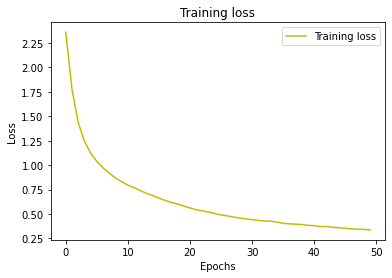

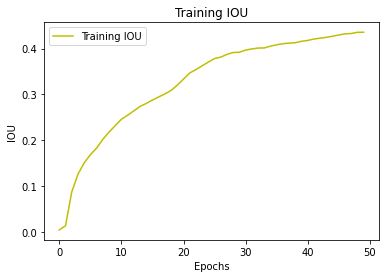

<Figure size 576x576 with 0 Axes>

In [46]:
trainingGraph(VGG16History)

In [ ]:
history2= model.fit(training_imgs, 
          y_masks,
          batch_size=32, 
          epochs=50,
          verbose=1)
#model2.save('res34_backbone_50epochs2.hdf5')
tf.saved_model.save(model, 'saved_model') 

Epoch 1/50
12/12 [==============================] - 142s 11s/step - loss: 1.0335 - iou_score: 0.0066 - f1-score: 0.0122
Epoch 2/50
12/12 [==============================] - 134s 11s/step - loss: 1.0224 - iou_score: 0.0313 - f1-score: 0.0512
Epoch 3/50
12/12 [==============================] - 133s 11s/step - loss: 1.0131 - iou_score: 0.0794 - f1-score: 0.1161
Epoch 4/50
12/12 [==============================] - 139s 12s/step - loss: 1.0064 - iou_score: 0.1269 - f1-score: 0.1705
Epoch 5/50
12/12 [==============================] - 133s 11s/step - loss: 1.0021 - iou_score: 0.1599 - f1-score: 0.2008
Epoch 6/50
12/12 [==============================] - 134s 11s/step - loss: 0.9985 - iou_score: 0.1796 - f1-score: 0.2189
Epoch 7/50
12/12 [==============================] - 133s 11s/step - loss: 0.9958 - iou_score: 0.1966 - f1-score: 0.2391
Epoch 8/50
12/12 [==============================] - 138s 11s/step - loss: 0.9930 - iou_score: 0.2188 - f1-score: 0.2687
Epoch 9/50
12/12 [======================

ValueError: ignored

In [47]:
VGG16.save_model("VGG16.hdf5")

AttributeError: ignored

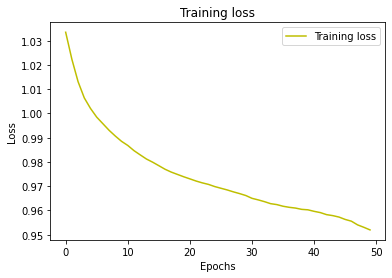

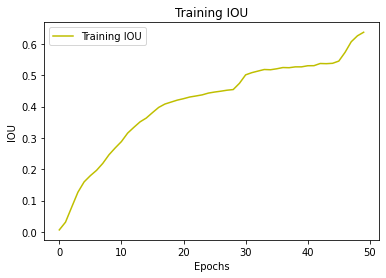

In [ ]:
trainingGraph(history2)

**Training on images with augmentation**

In [ ]:
trainimgPath2 = "/content/drive/MyDrive/dataset1 - Copy/images_prepped_train"
trainmaskPath2 = "/content/drive/MyDrive/dataset1 - Copy/annotations_prepped_train"
model2, training_imgs2,y_masks2, trainingMsks2 = training(trainimgPath2,trainmaskPath2)

/content/drive/MyDrive/dataset1 - Copy/images_prepped_train/1 (1).png img
/content/drive/MyDrive/dataset1 - Copy/images_prepped_train/1 (2).png img
/content/drive/MyDrive/dataset1 - Copy/images_prepped_train/1 (3).png img
/content/drive/MyDrive/dataset1 - Copy/images_prepped_train/1 (4).png img
/content/drive/MyDrive/dataset1 - Copy/images_prepped_train/1 (5).png img
/content/drive/MyDrive/dataset1 - Copy/images_prepped_train/1 (6).png img
/content/drive/MyDrive/dataset1 - Copy/images_prepped_train/1 (7).png img
/content/drive/MyDrive/dataset1 - Copy/images_prepped_train/1 (8).png img
/content/drive/MyDrive/dataset1 - Copy/images_prepped_train/1 (9).png img
/content/drive/MyDrive/dataset1 - Copy/images_prepped_train/1 (10).png img
/content/drive/MyDrive/dataset1 - Copy/images_prepped_train/1 (11).png img
/content/drive/MyDrive/dataset1 - Copy/images_prepped_train/1 (12).png img
/content/drive/MyDrive/dataset1 - Copy/images_prepped_train/1 (13).png img
/content/drive/MyDrive/dataset1 - 

/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Model: "model_9"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 data (InputLayer)              [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 bn_data (BatchNormalization)   (None, None, None,   9           ['data[0][0]']                   
                                3)                                                                
                                                                                                  
 zero_padding2d_136 (ZeroPaddin  (None, None, None,   0          ['bn_data[0][0]']                
 g2D)                           3)                                                          

In [ ]:
history2= model2.fit(training_imgs2, 
          y_masks2,
          batch_size=32, 
          epochs=50,
          verbose=1)
#model2.save('res34_backbone_50epochs2.hdf5')
tf.saved_model.save(model2, 'saved_model') 

Epoch 1/50
23/23 [==============================] - 270s 11s/step - loss: 1.0225 - iou_score: 0.0231 - f1-score: 0.0314
Epoch 2/50
23/23 [==============================] - 261s 11s/step - loss: 1.0026 - iou_score: 0.1142 - f1-score: 0.1481
Epoch 3/50
23/23 [==============================] - 266s 12s/step - loss: 0.9963 - iou_score: 0.1770 - f1-score: 0.2352
Epoch 4/50
23/23 [==============================] - 261s 11s/step - loss: 0.9925 - iou_score: 0.2215 - f1-score: 0.2935
Epoch 5/50
23/23 [==============================] - 263s 11s/step - loss: 0.9892 - iou_score: 0.2473 - f1-score: 0.3198
Epoch 6/50
23/23 [==============================] - 261s 11s/step - loss: 0.9868 - iou_score: 0.2650 - f1-score: 0.3379
Epoch 7/50
23/23 [==============================] - 261s 11s/step - loss: 0.9847 - iou_score: 0.2835 - f1-score: 0.3580
Epoch 8/50
23/23 [==============================] - 266s 12s/step - loss: 0.9823 - iou_score: 0.3043 - f1-score: 0.3801
Epoch 9/50
23/23 [======================

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


ValueError: ignored

In [ ]:

from keras.models import load_model
model = load_model('/content/drive/MyDrive/res34_backbone_50epochs2.hdf5', compile=False)

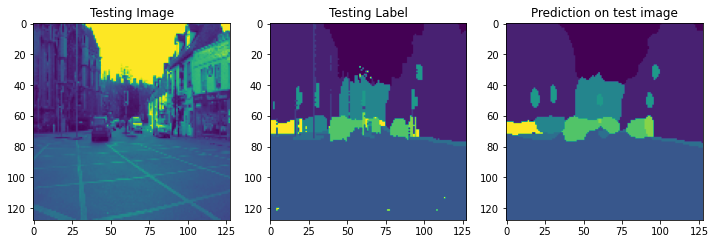

In [ ]:
preprocess_input = sm.get_preprocessing("resnet34")
test_img_number = random.randint(0, len(training_imgs) -1)
test_img = training_imgs[test_img_number]
ground_truth=y_masks[test_img_number]
test_img_input=np.expand_dims(test_img, 0)

test_img_input1 = preprocess_input(test_img_input)

test_pred1 = model.predict(test_img_input1)



test_prediction1 = np.argmax(test_pred1, axis=3)[0,:,:]


plt.figure(figsize=(12, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img[:,:,0])
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(trainingMsks[test_img_number])
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(test_prediction1)
plt.show()

In [ ]:
from skimage import color
result_image = color.label2rgb(test_prediction1, training_imgs[test_img_number])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: The new recommended value for bg_label is 0. Until version 0.19, the default bg_label value is -1. From version 0.19, the bg_label default value will be 0. To avoid this warning, please explicitly set bg_label value.
  


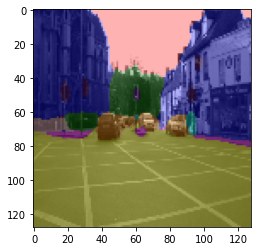

In [ ]:
plt.imshow(result_image)

In [ ]:
result_image = color.label2rgb(trainingMsks[test_img_number],test_img )

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: The new recommended value for bg_label is 0. Until version 0.19, the default bg_label value is -1. From version 0.19, the bg_label default value will be 0. To avoid this warning, please explicitly set bg_label value.
  """Entry point for launching an IPython kernel.


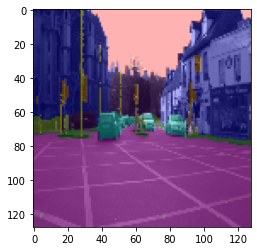

In [ ]:
plt.imshow(result_image)

In [ ]:
import tensorflow as tf
import keras.backend as K
from keras.losses import binary_crossentropy

beta = 0.25
alpha = 0.25
gamma = 2
epsilon = 1e-5
smooth = 1
def dice_coef( y_true, y_pred):
        y_true_f = K.flatten(y_true)
        y_pred_f = K.flatten(y_pred)
        intersection = K.sum(y_true_f * y_pred_f)
        return (2. * intersection + K.epsilon()) / (
                    K.sum(y_true_f) + K.sum(y_pred_f) + K.epsilon())
def f1( y_true, y_pred):
        y_true_f = K.flatten(y_true)
        y_pred_f = K.flatten(y_pred)
        intersection = K.sum(y_true_f * y_pred_f)
        v1 =  K.sum(y_true_f) / intersection
        v2 =  K.sum(y_pred_f)/ intersection
        return (2+ K.epsilon()) / (
                   v1 + v2 + K.epsilon())        
def sensitivity( y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        return true_positives / (possible_positives + K.epsilon())
        
def specificity( y_true, y_pred):
        true_negatives = K.sum(
            K.round(K.clip((1 - y_true) * (1 - y_pred), 0, 1)))
        possible_negatives = K.sum(K.round(K.clip(1 - y_true, 0, 1)))
        return true_negatives / (possible_negatives + K.epsilon())        
class Semantic_loss_functions(object):
    def __init__(self):
        print ("semantic loss functions initialized")

    

    

    

    def convert_to_logits(self, y_pred):
        y_pred = tf.clip_by_value(y_pred, tf.keras.backend.epsilon(),
                                  1 - tf.keras.backend.epsilon())
        return tf.math.log(y_pred / (1 - y_pred))

    def weighted_cross_entropyloss(self, y_true, y_pred):
        y_pred = self.convert_to_logits(y_pred)
        pos_weight = beta / (1 - beta)
        loss = tf.nn.weighted_cross_entropy_with_logits(logits=y_pred,
                                                        targets=y_true,
                                                        pos_weight=pos_weight)
        return tf.reduce_mean(loss)

    def focal_loss_with_logits(self, logits, targets, alpha, gamma, y_pred):
        weight_a = alpha * (1 - y_pred) ** gamma * targets
        weight_b = (1 - alpha) * y_pred ** gamma * (1 - targets)

        return (tf.math.log1p(tf.exp(-tf.abs(logits))) + tf.nn.relu(
            -logits)) * (weight_a + weight_b) + logits * weight_b

    def focal_loss(self, y_true, y_pred):
        y_pred = tf.clip_by_value(y_pred, tf.keras.backend.epsilon(),
                                  1 - tf.keras.backend.epsilon())
        logits = tf.math.log(y_pred / (1 - y_pred))

        loss = self.focal_loss_with_logits(logits=logits, targets=y_true,
                                      alpha=alpha, gamma=gamma, y_pred=y_pred)

        return tf.reduce_mean(loss)

    def depth_softmax(self, matrix):
        sigmoid = lambda x: 1 / (1 + K.exp(-x))
        sigmoided_matrix = sigmoid(matrix)
        softmax_matrix = sigmoided_matrix / K.sum(sigmoided_matrix, axis=0)
        return softmax_matrix

    def generalized_dice_coefficient(self, y_true, y_pred):
        smooth = 1.
        y_true_f = K.flatten(y_true)
        y_pred_f = K.flatten(y_pred)
        intersection = K.sum(y_true_f * y_pred_f)
        score = (2. * intersection + smooth) / (
                    K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
        return score

    def dice_loss(self, y_true, y_pred):
        loss = 1 - self.generalized_dice_coefficient(y_true, y_pred)
        return loss

    def bce_dice_loss(self, y_true, y_pred):
        loss = binary_crossentropy(y_true, y_pred) + \
               self.dice_loss(y_true, y_pred)
        return loss / 2.0

    def confusion(self, y_true, y_pred):
        smooth = 1
        y_pred_pos = K.clip(y_pred, 0, 1)
        y_pred_neg = 1 - y_pred_pos
        y_pos = K.clip(y_true, 0, 1)
        y_neg = 1 - y_pos
        tp = K.sum(y_pos * y_pred_pos)
        fp = K.sum(y_neg * y_pred_pos)
        fn = K.sum(y_pos * y_pred_neg)
        prec = (tp + smooth) / (tp + fp + smooth)
        recall = (tp + smooth) / (tp + fn + smooth)
        return prec, recall

    def true_positive(self, y_true, y_pred):
        smooth = 1
        y_pred_pos = K.round(K.clip(y_pred, 0, 1))
        y_pos = K.round(K.clip(y_true, 0, 1))
        tp = (K.sum(y_pos * y_pred_pos) + smooth) / (K.sum(y_pos) + smooth)
        return tp

    def true_negative(self, y_true, y_pred):
        smooth = 1
        y_pred_pos = K.round(K.clip(y_pred, 0, 1))
        y_pred_neg = 1 - y_pred_pos
        y_pos = K.round(K.clip(y_true, 0, 1))
        y_neg = 1 - y_pos
        tn = (K.sum(y_neg * y_pred_neg) + smooth) / (K.sum(y_neg) + smooth)
        return tn

    def tversky_index(self, y_true, y_pred):
        y_true_pos = K.flatten(y_true)
        y_pred_pos = K.flatten(y_pred)
        true_pos = K.sum(y_true_pos * y_pred_pos)
        false_neg = K.sum(y_true_pos * (1 - y_pred_pos))
        false_pos = K.sum((1 - y_true_pos) * y_pred_pos)
        alpha = 0.7
        return (true_pos + smooth) / (true_pos + alpha * false_neg + (
                    1 - alpha) * false_pos + smooth)

    def tversky_loss(self, y_true, y_pred):
        return 1 - self.tversky_index(y_true, y_pred)

    def focal_tversky(self, y_true, y_pred):
        pt_1 = self.tversky_index(y_true, y_pred)
        gamma = 0.75
        return K.pow((1 - pt_1), gamma)

    def log_cosh_dice_loss(self, y_true, y_pred):
        x = self.dice_loss(y_true, y_pred)
        return tf.math.log((tf.exp(x) + tf.exp(-x)) / 2.0)

In [ ]:

dice_coefficient_test = []
sensitivity_test =[]
specificity_test = []
preprocess_input = sm.get_preprocessing("resnet34")
test_img_number = random.randint(0, len(training_imgs) -1)
test_img = training_imgs[test_img_number]
ground_truth=y_masks[test_img_number]
test_img_input=np.expand_dims(test_img, 0)
test_img_input1 = preprocess_input(test_img_input)
#test_pred1 = model.predict(test_img_input1)
y_test = model.predict(test_img_input1)
test_mask=ground_truth.astype(np.float32)
dice_coefficient_test.append(K.eval(dice_coef(test_mask, y_test)))
sensitivity_test.append(K.eval(sensitivity(test_mask,y_test)))
specificity_test.append(K.eval(specificity(test_mask,y_test)))
print ("average of Dice Coefficient, Sensitivity, Specificity", dice_coefficient_test, sensitivity_test, specificity_test)

average of Dice Coefficient, Sensitivity, Specificity [0.92823875] [0.9476929] [0.99638784]


In [ ]:
!pip install torchvision 

In [ ]:
!ls /content/drive/MyDrive/

 00066_00002.ppm
'Advanced Computer Vision'
 AffectNet-master
'April 15 - Thursday-20210415_144235-Meeting Recording.mp4'
'April 16 - Friday-20210416_160709-Meeting Recording.mp4'
 Assignment3
'Attributes (1).csv'
 Attributes.csv
 augmentedimgs
 augmentedmasks
 classificator_weights.h5
'Colab Notebooks'
'Copy of test_set.tar'
'Copy of train_and_val_set.tar'
 dataset1
'dataset1 - Copy'
 emonet_5.pth
 features.csv
 Fid.pdf
 full_labels_for_deep_learning
'Game Theory I - Kevin Leyton-Brown'
 images
 images2.csv
'img3 (1).csv'
 img3.csv
'img4 (1).csv'
 img4.csv
 img5.csv
 imgs.csv
 paths.csv
'Project Proposal Template.gdoc'
 res34_backbone_50epochs2.hdf5
 submission2.csv
'Task assignment papers.zip'
 tdata
 testd
 testdaa
 TestingData
 testing_dataA2
 test_set
 train
 TrainData
 TrainingData
 training_dataA2
 trainining_images
 train_set
'Untitled Folder'
'Week 2- Lecture 2-20210312_190258-Meeting Recording.mp4'
 weightd.h5


In [51]:
cd /content/drive/MyDrive

/content/drive/MyDrive


In [54]:
tf.saved_model.save(vgg16, 'vgg16_model') 

INFO:tensorflow:Assets written to: vgg16_model/assets
